# Analisis de la base de datos

# Primeros pasos

#### Empezemos por importar las librerias y cargar el DataFrame.

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
import math

pd.set_option('display.width', 1000)

df = pd.read_csv('transf_data.csv', sep=',')

Aca encontramos definidas las funciones que vamos a usar a travez de todo el analisis y creacion de la red. Varias no son necesarias para esta base de datos, pero si para la de 'Water Potability'.

In [61]:
# ============================================== SCRIPT DE FUNCIONES ===================================================== #

# Funcion de descarte
# Asigna a un nuevo dataframe, otro pero con los indices dropeados de las filas que cumplan la condicion pasada
# Ejemplo: Si quiero armar un nuevo dataframe sin las filas donde la potabilidad es 0:
# df_1 = descarte(df, 'Potability', 1) => Esto se guarda todas las filas donde Potabilidad es 1
def descarte(data_frame, columna, dato):
    new_df = data_frame.copy()
    indexes = new_df[new_df[columna] != dato].index
    return new_df.drop(indexes)

# Cargadora de NaNs
def carga_nans(data_frame, data_ceros, data_unos):
    # Aca por las dudas hago lo mismo, igual se lo voy a asignar al original
    new_df = data_frame.copy()
    columnas = new_df.columns.to_list()
    # Esto devuelve:
    # index = indice de la fila
    # fila = todos los datos de la fila en un [[formato]]
    for index, fila in new_df.iterrows():
        # Y por cada fila del dataframe, itero en las columnas
        for i in range(9):
            # Cuando i = 0 > fila['ph'], cuando i = 1 > fila['Hardness']
            if math.isnan(fila.iloc[i]) and fila.iloc[9] == 0:
                new_df.loc[index, columnas[i]] = data_ceros[columnas[i]].median()
            elif math.isnan(fila.iloc[i]) and fila.iloc[9] == 1:
                new_df.loc[index, columnas[i]] = data_unos[columnas[i]].median()
    return new_df

# Normalizacion
def normalizacion(data_frame):
    # Se agrego esto, sino se esta modificando el dataframe original, y no quiero eso. Se modifica en todas las funciones
    new_df = data_frame.copy() # <-
    columnas = new_df.columns.to_list()
    new_val = []
    for item in columnas[:-1]:
        max_value = new_df[item].max()
        for value in new_df[item]:   
            new_val.append(value/max_value)
        new_df[item] = new_val
        new_val.clear()
    return new_df

# Borrador de valores atipicos
def atipicos(valores_columna):
    ordered = sorted(valores_columna)
    n = len(valores_columna)
    Q1 = ordered[n // 4]
    Q2 = (ordered[n // 2 - 1] + ordered[n // 2]) / 2
    Q3 = ordered[3 * n // 4]
    iqr = Q3 - Q1
    # print('Max value: ', Q3 + (1.5 * iqr))
    # print('Min value: ', Q1 - (1.5 * iqr))
    # print('\n')
    # Entonces lo que quiero hacer es: Primero identificar los atipicos. Despues buscar esos atipicos 
    # en el dataframe, y eliminarlos. NO se hace con el indice xq son indices dis-
    # tintos, la columna no esta ordenada, 'ordered' si.
    values = []
    for value in ordered:
        if ((value > Q3 + (1.5 * iqr)) or (value < Q1 - (1.5 * iqr))):
            values.append(value)
    return values, iqr

def limpieza(data_frame):
    new_df = data_frame.copy()
    columnas = new_df.columns.to_list()
    for item in columnas[:-1]:
        indices = []
        valores_at = atipicos(new_df[item].to_list())[0]
        for value in valores_at:
            # Guarda en la lista los indices de las filas que sean iguales al value
            indices.append(new_df[new_df[item] == value].index[0])
        # Y despues las tira todas a la bosta
        new_df = new_df.drop(indices)
    return new_df

# Estandarizacion
def estandarizacion(data_frame):
    new_df = data_frame.copy()
    columnas = data_frame.columns.to_list()
    for item in columnas[:-1]:
        # media
        media = new_df[item].mean()
        # desviacion estandar
        desv_std = new_df[item].std()
        # lista para guardar los valores escalados
        valores_esc = []
        for value in new_df[item]:
            # estandariza
            val = ((value - media) / desv_std) 
            # guarda
            valores_esc.append(val)
        # mete toda la lista en la columna
        new_df[item] = valores_esc
    
    return new_df

# Estandarizacion Robusta
# Esto se tiene que llamar una vez que no haya NaNs.
def estandarizacion_robusta(data_frame):
    new_df = data_frame.copy()
    columnas = data_frame.columns.to_list()
    iqr = 0
    for item in columnas[:-1]:
        # media
        iqr = atipicos(new_df[item].to_list())[1]
        # desviacion estandar
        desv_std = new_df[item].std()
        # lista para guardar los valores escalados
        valores_esc = []
        for value in new_df[item]:
            # estandariza
            val = ((value - iqr) / desv_std)
            # guarda
            valores_esc.append(val)
        # mete toda la lista en la columna
        new_df[item] = valores_esc
    
    return new_df

def borrador_samples(data_frame):
    new_df = data_frame.copy()
    indices = []
    for index,value in new_df.iterrows():
        if new_df['fraud'][index] == 0:
            indices.append(index)
        if (index == 820_000):
            newnew_df = new_df.drop(indices)
            return newnew_df
        
# ============================================================================================================================ #

# ============================================== GRAFICOS ===================================================== #

# Graficos de dispersion de los datos
def scattered(df, last_col, max_x = None, max_y = None):
    columns = df.columns.to_list()
    for item in columns[:last_col]:
        if max_x is None:
            max_x = df[item].index.max()
        if max_y is None:
            max_y = df[item].max()
        plt.xlabel('Index')
        plt.xlim(0, max_x)
        plt.ylim(0, max_y)
        plt.ylabel(f'Column \'{item}\'')
        plt.xticks(rotation=45, horizontalalignment='center')
        plt.minorticks_on()
        plt.grid()
        plt.title('PLOT PER COLUMN')
        plt.scatter(df.index, df[item], label=item.upper(), color='slateblue', marker='.')
        plt.legend()
        plt.show()

# Graficos de distribucion (boxplot)
def boxplot(data_frame, last_col):
    columnas = data_frame.columns.to_list()
    fig, ax = plt.subplots(last_col, 1, figsize=(10, 20))
    fig.subplots_adjust(hspace=0.75)
    for i in range(last_col):
        sns.boxplot(x=data_frame[columnas[i]], data=data_frame, ax=ax[i])
    plt.show()

# Histogramas de los datos
def histograms(df, last_col):
    new_df = df.copy()
    columns = new_df.columns.to_list()
    for item in columns[:last_col]:
        
        media = new_df[item].mean()
        desv_est = new_df[item].std()
        array = new_df[item].to_numpy()

        plt.xlabel(f'Column \'{item}\'')
        plt.ylabel('Index')
        plt.xticks(rotation=45, horizontalalignment='center')
        plt.minorticks_on()
        plt.grid()
        plt.title('PLOT PER COLUMN')

        cont, bins, patches = plt.hist(array, color='slateblue', edgecolor='black', density=True, alpha=0.6, label=item.upper())
        x_densidad = np.linspace(bins[0], bins[-1], 100)

        funcion = 1/(desv_est*np.sqrt(2*np.pi)) * np.exp(-0.5*((x_densidad - media)/desv_est)**2)

        plt.plot(x_densidad, funcion, linewidth=2, color='black')
        plt.legend()
        plt.show()

# Matriz de correlacion
def matrix_corr(df):
    plt.figure(figsize=(10, 8))
    matriz_corr = df.corr()
    # Colores para la grafica de correlacion -> https://matplotlib.org/stable/users/explain/colors/colormaps.html
    sns.heatmap(matriz_corr, annot=True, cmap='inferno', linewidths=0.3, vmin=-1)
    plt.xticks(rotation=45, horizontalalignment='center')
    plt.title('Correlation Matrix')
    plt.show()

# Pares de graficos en funciones del resto
def pplot(data_frame, hue):
    sns.pairplot(data_frame, hue=hue, corner=True, palette='plasma')
    plt.show()

# Grafico del entrenamiento de la red (test/train)
def grafico_acc(L, train_l, test_l):
    fmt_train = {
        'color': 'tab:red',
        'ls': 'solid',
        'lw': 3,
    }

    fmt_test = {
        'color': 'tab:orange',
        'ls': 'solid',
        'lw': 3,
    }

    fig, (ax) = plt.subplots(1, 1, figsize=(10,8))

    ax.plot(train_l, label='Train', **fmt_train)
    ax.plot(test_l, label='Test', **fmt_test)

    ax.grid(which='both')
    ax.legend()
    ax.set_title(f'Accuracy {L=}')
    ax.set_xlabel('Step')

    fig.tight_layout()
    plt.show()

# ============================================================================================================= #

Primer vistazo de los datos.

In [62]:
print('\n','Drescripcion del DF sin procesar', '\n\n', df.describe(), sep='')
print('\n','15 Primeras filas', '\n\n',df.head(15), sep='')
nans = df[df.columns[df.isnull().any()]]
print('\n','NaNs por columna', '\n\n',(nans.isnull().sum()), sep='')


Drescripcion del DF sin procesar

       distance_from_home  distance_from_last_transaction  ratio_to_median_purchase_price  repeat_retailer      used_chip  used_pin_number   online_order          fraud
count       251648.000000                   251648.000000                   251648.000000    251648.000000  251648.000000    251648.000000  251648.000000  251648.000000
mean            37.774015                        7.267704                        3.016502         0.880762       0.323718         0.072160       0.734681       0.347322
std             93.023494                       34.096929                        4.234568         0.324069       0.467895         0.258754       0.441504       0.476120
min              0.025847                        0.000298                        0.007278         0.000000       0.000000         0.000000       0.000000       0.000000
25%              4.018835                        0.306884                        0.588911         1.000000       0.00000

En un principio, teniamos 1.000.000 de datos! Lo primero que hicimos fue reducir la cantidad. Primero llamamos a 'borrador_samples', que se ocupa de iterar por el DataFrame guardando las primeras 820.000 posiciones donde haya 0 en la columna de 'fraud', despues borra las filas completas del DataFrame y lo retorna. ¿Por que hacemos esto? Aproximadamente 910.000 datos, concluian en no ser fraudes por transacciones. Concluimos en que tener 100.000 y 
80.000 datos de cada tipo, era mas que suficiente para entrenar la red.
Despues de este llamado, quedamos con 251.648 datos para utilizar. Mas tarde, llamaremos a 'limpieza', que se ocupa de borrar los atipicos de todas las columnas, quedandonos en total 180.304 datos.
El codigo de abajo fue utilizado para limpiar el CSV. Ahora en la carpeta, hay dos CSV, el original, y el extraido, generado gracias a la limpieza.

    # borra 820_000 datos de ceros
    # para dejar aproximadamente 80k y 80k
    df = borrador_samples(df)
    df = limpieza(df)
    df.to_csv('transf_data.csv', index=False)

Una vez realizada una limpieza general, podemos visualizar mejor los datos.

In [ ]:
# Parametros opcionales para scattered <-
# max_x => valor maximo del eje x, sino por defecto es el maximo indice.
# max_y =>   "     " pero del eje y. idem por defecto pero es el maximo valor.   
scattered(df, 1)

In [ ]:
# Estos se ven bastante feos <-
boxplot(df, 7)

In [ ]:
matrix_corr(df)

In [ ]:
pplot(df, 'fraud')

Ahora que ya tenemos una idea del DataFrame, podemos darnos cuenta de que no hace falta tratar mucho mas los datos. Vamos a proceder a estandarizarlos borrar los atipicos como ya habiamos dicho, con la funcion 'limpieza', para despues estandarizarlos con la funcion del script 'estandarizacion', la cual itera por cada columna, cargando en una lista los datos realizando la siguiente cuenta: ((dato - media) / desviacion estandar), para despues reasignar la lista nueva a cada columna.

In [63]:
df = limpieza(df)
df = estandarizacion(df)

Verifiquemos como quedaron los datos

In [64]:
print('\n','Drescripcion del DF post procesamiento', '\n\n', df.describe(), sep='')
print('\n','15 Primeras filas', '\n\n',df.head(15), sep='')
nans = df[df.columns[df.isnull().any()]]
print('\n','NaNs por columna', '\n\n',(nans.isnull().sum()), sep='')
print(df.index)


Drescripcion del DF post procesamiento

       distance_from_home  distance_from_last_transaction  ratio_to_median_purchase_price  repeat_retailer     used_chip  used_pin_number  online_order          fraud
count        1.803040e+05                    1.803040e+05                    1.803040e+05     1.803040e+05  1.803040e+05     1.803040e+05  1.803040e+05  180304.000000
mean        -9.285520e-18                    1.222437e-16                   -3.052547e-16     1.613217e-16  4.224542e-17    -2.167442e-19  3.176288e-17       0.239179
std          1.000000e+00                    1.000000e+00                    1.000000e+00     1.000000e+00  1.000000e+00     1.000000e+00  1.000000e+00       0.426584
min         -9.290139e-01                   -8.268459e-01                   -1.004304e+00    -2.528100e+00 -7.299695e-01    -2.958007e-01 -1.565729e+00       0.000000
25%         -7.101323e-01                   -6.941931e-01                   -7.685185e-01     3.955518e-01 -7.299695e-01    

# RED NEURONAL

Ahora si, la _**Red Neuronal**_. Primero vamos a separar los datos en entrenamiento y testeo, para despues definiar la funcion para entrenar la red.
Se van a definir valores random para la capa oculta y los sesgos. Estos valores se multiplican por 2 y se les resta uno, para obtener asi tambien valores negativos. Una vez definidas las funciones ReLu y Sigmoide, armamos la funcion del _**Forward Propagation**_, la cual aplica las multiplicaciones matriciales correspondientes hasta llegar a la salida, y _**Backward Propagation**_, que se encarga de redistribuir el error entre las capas utilizando las derivadas, actualizando los pesos y sesgos para un error menor la proxima iteracion. <-

#### Arquitectura de la red
aca hay que poner el dibujo de la red y las matrices

- Capas
    - La red dispondria de 3 capas: 1 de entrada, 1 capa oculta y 1 de salida.

- Neuronas
    - En la capa de entrada habra 7 neuronas (datos de entrada), en la capa oculta, habra 4 neuronas, y en la ultima 1 sola, ya que es 1 si es fraude o 0 si no lo es.

- Funciones de Activacion
    - ReLu en las ocultas, Sigmoide en la de salida

Comenzamos con la red.
Primero, separamos los datos en entrenamiento y testeo.

In [65]:
# Extraigo las columnas de entrada
inputs = df.iloc[:, 0:7].values
outputs = df.iloc[:, -1].values

# Conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=1/3)

#shape retorna una tupla con las dimensiones de la matriz = (filas, columnas).
# por lo que shape[0], nos retorna las filas de la matriz.
n_train = x_train.shape[0] # numero de registros de entrenamiento

Y ahora si, construimos la Red Neuronal.

In [66]:
def red_neuronal(L, epochs):
    np.random.seed(0)
    # pesos
    w_hidden_1 = np.random.rand(4,7) * 2 - 1
    w_output_1 = np.random.rand(1,4) * 2 - 1

    # sesgos
    b_hidden = np.random.rand(4,1) * 2 - 1
    b_output = np.random.rand(1,1) * 2 - 1

    # Funciones de Activacion
    relu = lambda x: np.maximum(x, 0)
    sigmoide = lambda x: 1 / (1 + np.exp(-x))

    def f_prop(X):
        z1 = w_hidden_1 @ X + b_hidden
        a1 = relu(z1)
        z2 = w_output_1 @ a1 + b_output
        a2 = sigmoide(z2)
        return z1, a1, z2, a2

    # Derivadas de las funciones de activación
    d_relu = lambda x: x > 0
    d_sigmoide = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

    # Devuelve pendientes para pesos y sesgos
    # usando la regla de la cadena
    def b_prop(z1, a1, z2, a2, X, Y):
        dC_dA2 = 2 * a2 - 2 * Y
        dA2_dZ2 = d_sigmoide(z2)
        dZ2_dA1 = w_output_1
        dZ2_dW2 = a1
        dZ2_dB2 = 1
        dA1_dZ1 = d_relu(z1)
        dZ1_dW1 = X
        dZ1_dB1 = 1

        dC_dW2 = dC_dA2 @ dA2_dZ2 @ dZ2_dW2.T
        dC_dB2 = dC_dA2 @ dA2_dZ2 * dZ2_dB2
        dC_dA1 = dC_dA2 @ dA2_dZ2 @ dZ2_dA1
        dC_dW1 = dC_dA1 @ dA1_dZ1 @ dZ1_dW1.T
        dC_dB1 = dC_dA1 @ dA1_dZ1 * dZ1_dB1

        return dC_dW1, dC_dB1, dC_dW2, dC_dB2

    # Para el grafico de las funciones
    accuracy_train_l = []
    accuracy_test_l = []

    # Ejecutar descenso de gradiente
    for i in range(epochs):
        # seleccionar aleatoriamente uno de los datos de entrenamiento
        idx = np.random.choice(n_train, 1, replace=False)
        X_sample = x_train[idx].transpose()
        Y_sample = y_train[idx]
        
        # pasar datos seleccionados aleatoriamente a través de la red neuronal
        Z1, A1, Z2, A2 = f_prop(X_sample)

        # distribuir error a través de la retropropagación
        # y devolver pendientes para pesos y sesgos
        dW1, dB1, dW2, dB2 = b_prop(Z1, A1, Z2, A2, X_sample, Y_sample)

        # actualizar pesos y sesgos
        w_hidden_1 -= L * dW1
        b_hidden -= L * dB1
        w_output_1 -= L * dW2
        b_output -= L * dB2

        # Accuracy
        # Test
        test_predictions = f_prop(x_test.transpose())[3]
        test_comparisons = np.equal((test_predictions >= .5).flatten().astype(int), y_test)
        accuracy_test = sum(test_comparisons.astype(int) / x_test.shape[0])
        accuracy_test_l.append(accuracy_test)
        
        # Train
        train_predictions = f_prop(x_train.transpose())[3]
        train_comparisons = np.equal((train_predictions >= .5).flatten().astype(int), y_train)
        
        accuracy_train = sum(train_comparisons.astype(int) / x_train.shape[0])
        accuracy_train_l.append(accuracy_train)

    print("TRAIN ACCURACY: ", accuracy_train)
    print("TEST ACCURACY: ", accuracy_test)
    print(f'Epochs: {epochs}')
    print(f'Paso: {L}')
    grafico_acc(L=L, train_l=accuracy_train_l, test_l=accuracy_test_l)


Y ahora si, procedemos a entrenar la red

TRAIN ACCURACY:  0.9761068867385796
TEST ACCURACY:  0.9754084722647974
Epochs: 20000
Paso: 0.01


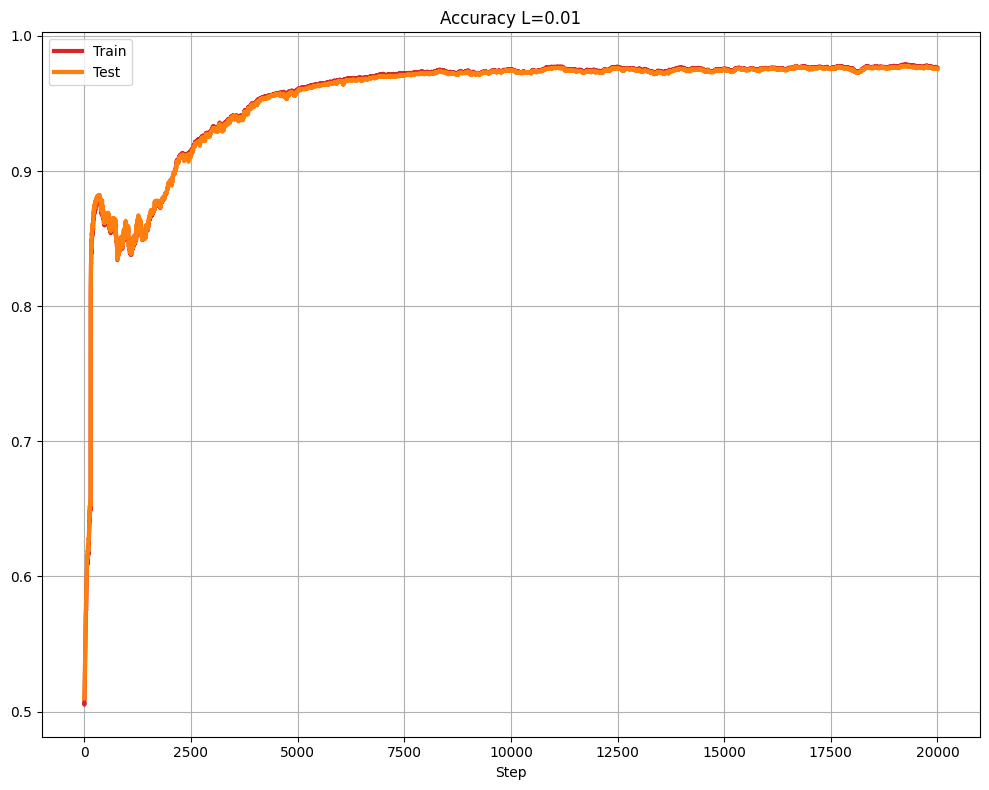

TRAIN ACCURACY:  0.9808489043422568
TEST ACCURACY:  0.9796512595264637
Epochs: 20000
Paso: 0.03


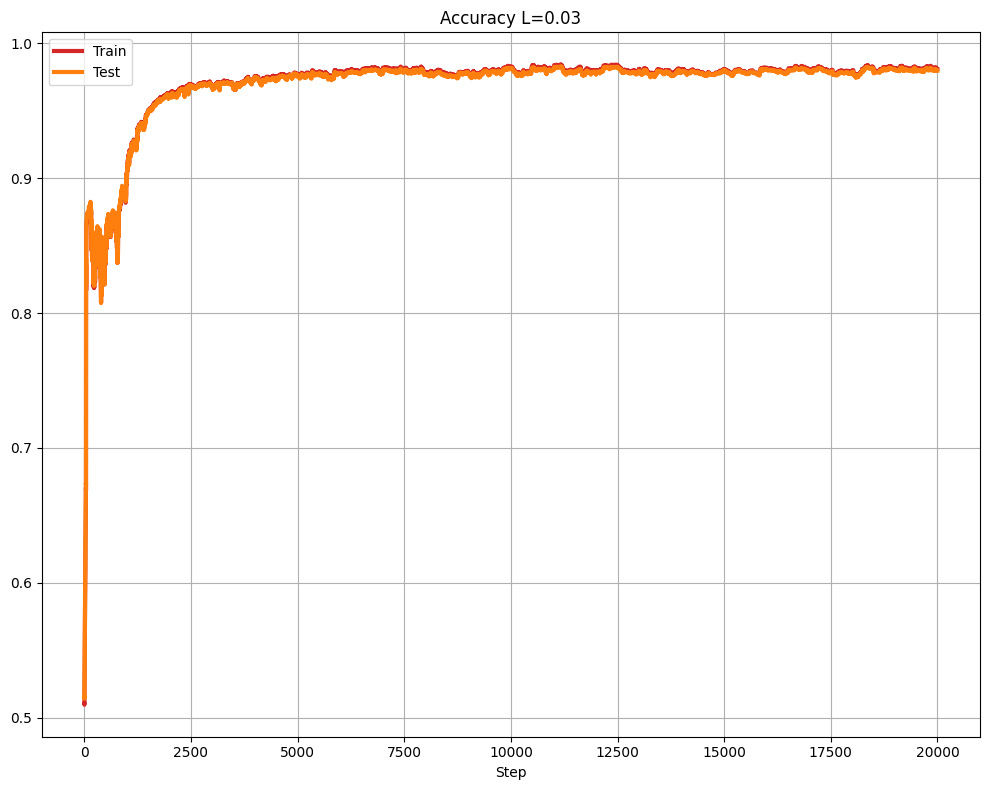

In [68]:
epochs = [20_000]
eles = [.01, .03]

for rep in epochs:
    for ele in eles:
        red_neuronal(L=ele, epochs=rep)

Por aca podriamos armar algo para pasarle a la red, y que intente pegarle. Pasa que ni nosotros sabemos cuando es y no fraude o potable jsjaja